In [1]:
pwd

u'/home/riddhisw/Documents/2017/Scripts_Git'

In [2]:
import GPy, numpy as np 
from matplotlib import pyplot as plt
from gprtf.common import get_data

In [3]:
test_case = 19
variation = 7
n_train = 2000
Delta_T = 0.001
sigma = 1.0 #1.42007514e-06
R =  1.0
SigmaMax = 1000.0
Rmax = 100.0
# sigma and periodicity move together.
# unconstrained == periodicity --> infinity, sigma --> large, predictions -->zero
# failure = increasing periodicity (algorithm appears to be predicting zero)

In [4]:
x, y, testx, truth, n_predict= get_data(test_case, variation, randomize='n')
num = truth.shape[0]
X = x[0:n_train,np.newaxis]
Y = y[0:n_train,np.newaxis]
f_0 = 1.0/n_train #num
w_0 = 2.0*np.pi*f_0
period = 2.0*np.pi / w_0
print period
print num == n_predict + n_train

('Shapes', 2000, 2000, (150,))
2000.0
True


In [5]:
kern1 = GPy.kern.RBF(1)
kern2 = GPy.kern.Matern32(1)
kern3 = GPy.kern.Matern52(1)
kern4 = GPy.kern.PeriodicExponential(1)
kern5 = GPy.kern.StdPeriodic(1, period=period, variance=sigma, lengthscale=3*Delta_T )

In [6]:
gauss = GPy.likelihoods.Gaussian(variance=R)
exact = GPy.inference.latent_function_inference.ExactGaussianInference()
m1 = GPy.core.GP(X=X, Y=Y, kernel=kern5, likelihood=gauss, inference_method=exact)
print m1


Name : gp
Objective : 306005823.764
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |  constraints  |  priors
  std_periodic.variance     |     1.0  |      +ve      |        
  std_periodic.period       |  2000.0  |      +ve      |        
  std_periodic.lengthscale  |   0.003  |      +ve      |        
  Gaussian_noise.variance   |     1.0  |      +ve      |        


k(x,y) = \theta_1 \exp \left[  - \frac{1}{2} \sum_{i=1}^{input\_dim}
   \left( \frac{\sin(\frac{\pi}{T_i} (x_i - y_i) )}{l_i} \right)^2 \right] }

In [7]:
m1.std_periodic.variance.constrain_bounded(0, SigmaMax)
m1.Gaussian_noise.variance.constrain_bounded(0, Rmax)
print(m1)


Name : gp
Objective : 306005823.764
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |  constraints  |  priors
  std_periodic.variance     |     1.0  |  0.0,1000.0   |        
  std_periodic.period       |  2000.0  |      +ve      |        
  std_periodic.lengthscale  |   0.003  |      +ve      |        
  Gaussian_noise.variance   |     1.0  |   0.0,30.0    |        


 /home/riddhisw/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1



Name : gp
Objective : 723393.95183
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |             value  |  constraints  |  priors
  std_periodic.variance     |     999.999903893  |  0.0,1000.0   |        
  std_periodic.period       |     1999.89424696  |      +ve      |        
  std_periodic.lengthscale  |  0.00105770546243  |      +ve      |        
  Gaussian_noise.variance   |     29.9993982332  |   0.0,30.0    |        


 /home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


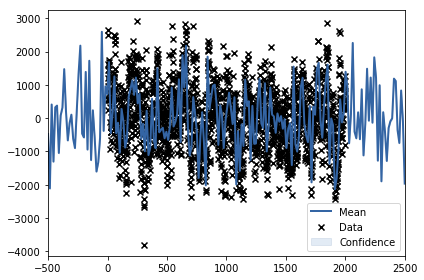

In [8]:
m1.optimize(messages=1, ipython_notebook=True)
_ = m1.plot()
print m1
plt.show()

In [9]:
predictions = m1.predict(testx[:,np.newaxis])[0].flatten()

In [10]:
plt.figure(figsize=(10,5))
plt.plot(testx, predictions, 'go', alpha=0.5, label='Predictions')
plt.plot(testx, truth[n_train-50:], 'r', label='Truth')
plt.plot(x[n_train-50:n_train], y[n_train-50:n_train], 'kx', label='Msmts')
plt.legend(loc=0)
plt.title('GPy PRE, Testcase %s Var %s RMax %s SigMax %s' %(test_case, variation, Rmax, SigmaMax))
plt.savefig('Gpy_PER_try2_tc_'+str(test_case)+'_var_'+str(variation))
plt.close()

In [11]:
truth.shape

(2100,)